In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import reference_ET
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

sys.path.append("../src/")
from sarra_py import *


In [2]:
grid_width = 1
grid_height = 1
duration = 365

In [3]:
from logging import exception


paramVariete = {

                # paramètres depuis Ag3 USA Hars v42_12_ p4 irr
                # # récupérés depuis HV42 parameters
                #variete mais iowa USA V42
                
                "SDJLevee":90, # OK
                "SDJBVP":320, # OK
                "SDJRPR":500, # OK
                "SDJMatu1":560, # OK
                "SDJMatu2":200, # OK
                
                "KRdtPotA": 0.8,  # OK
                "KRdtPotB": 200, # OK

                "PPExp" : 0, # OK
                "SeuilPP" : 13.6, # OK
                "PPsens" : 5, # OK
                "PPCrit": 11, # OK

                "TBase":8, # OK
                "TOpt1":26, # OK
                "TOpt2":34, # OK
                "TLim":44, # OK

                "pcReallocFeuille":0.7, # OK
                'txConversion':5.8, # OK
                'txAssimBVP':1, # OK
                'txAssimMatu1':0.9, # OK
                'txAssimMatu2':0.1,  # OK

                "kRespMaint":0.01, # OK
                "aeroTotBase":0.6, # OK
                "aeroTotPente":5E-5, # OK
                "feuilAeroBase":0.55, # OK
                "feuilAeroPente":-5E-5, # OK

                "txRealloc":0.4, # OK
                "tempMaint":25, # OK
                "KRdtBiom":0, # OK
                
                "kcMax":1.25, # OK
                # "txRuSurfGermi":0.8,
                "PFactor":0.45, # OK
                "seuilCstrMortality":3, # OK

                'kdf': 0.4,  # OK
                "poidsSecGrain":0.38, # OK
                "txResGrain":0.55, # OK

                "VRacLevee":30.0, # OK
                "VRacBVP":15.0, # OK
                "VRacPSP":15.0, # OK
                "VRacRPR":15.0, # OK
                "VRacMatu1":12.0, # OK
                "VRacMatu2":12.0, # OK

                "slaMin":0.0016, # OK
                "slaMax":0.005, # OK
                "slaPente":0.4, # OK

                "phaseDevVeg":0, # OK
                "senCO2":10, # OK
                
                "densOpti":85000, # OK
                "densiteA":0.7, # OK
                "densiteP":4.5, # OK

                "NIYo":1,
                "NIp":0,
                "LGauss":1,
                "AGauss":1,

                #pas dans les params sarra-h
                "kTempMaint":25,
                "slaBVP":0.003,
                "slaRPR":0.003,
                "KpenteSla":1,
                "kBaseLaiDev":0.2,
                "kPenteLaiDev":0.5,
                }

if paramVariete["kBaseLaiDev"] == 0.1 :
    raise exception()

paramITK = {
            "DateSemis":datetime.date(2012,4,28), # OK
            "profRacIni":0,# OK
            "densite":86500, # OK
            "mulch":100,  # OK
            "seuilEauSemis":0, # OK
            "nbjTestSemis":0, # OK
            "irrigAuto":False, # OK
            "irrigAutoTarget":0, # OK
            "maxIrrig":0, # OK
            "precision":0, # OK
            "biomIniMc":0, # OK
            "humSatMc":0, # OK
            "surfMc":0, # OK
            "coefMc":0, # OK

            "KNUp":0, # OK
            "KNLit":0, # OK
            "KT":0, # OK
            "KI":0, # OK
            
            # non utilisés dans le modèle python
            "DisMc":000000, # OK
            "TxRecolte":0, # OK
            "TxaTerre":0, # OK
            "NbUBT":10, # OK
            
            # non présents dans sarra-h
            "dateFin":300,
            "NI":1, 

            
            
            }

paramTypeSol = {
                "stockIniSurf":30, # OK
                "stockIniProf":170, # OK
                "epaisseurSurf": 200, # OK
                "epaisseurProf" : 1300, # OK

                # params type sol
                "seuilRuiss":20, # OK
                "pourcRuiss":30/100, # OK
                "ru":132, # OK

                # non utilisés mais présents dans sarra-h
                "HumCR":0.32, # OK
                "HumPF":0.18, # OK
                'HumFC':0.32, # OK
                "HumSat":0.48, # OK
                "Pevap":0.2, # OK
                "PercolationMax":5, # OK

                }

# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

In [4]:
lat,long = 42.02, -93.75
date_start = datetime.date(2012,4,1)
duration = 250
 
 # getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=long, latitude=lat)
print(weatherdata)
df_weather = pd.DataFrame(weatherdata.export())
df_weather = df_weather[(df_weather["DAY"]>=date_start) & (df_weather["DAY"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)
df_weather.head()

df_weather["DOY"] = df_weather.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)
df_weather["ET0"] = df_weather["ET0"] * 10 #conversion cm to mm

df_weather["RAIN"] = df_weather["RAIN"] * 10 #conversion cm to mm

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:  310.2
Latitude:  42.020
Longitude: -93.750
Data available for 1984-01-01 - 2022-07-27
Number of missing days: 2



In [5]:
# alt with loading exported data from sarra-h

#lat,long = 42.02, -93.75
elevation = 329

df_weather = pd.read_csv("../data/Meteorologie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_rain = pd.read_csv("../data/Pluviometrie_US0001.txt", sep="\t", decimal=",", skiprows=1)
df_weather = df_weather.merge(df_rain, right_on=["Jour", "CodeStation"], left_on=["Jour", "CodeStation"])
df_weather["Jour"] = df_weather.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather[(df_weather["Jour"]>=date_start) & (df_weather["Jour"]<=date_start+datetime.timedelta(days=duration-1))].reset_index(drop=True)

df_weather = df_weather.rename(columns={"Pluie":"RAIN"})

In [6]:
"""def _estimate_AngstAB(self, df_power):
        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and
        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.
        :param df_power: dataframe with POWER data
        :return: tuple of Angstrom A/B values
        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn
        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for
        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while
        toa_dwn*A approaches the lower envelope of the records of swv_dwn
        values.
        """

'def _estimate_AngstAB(self, df_power):\n        Determine Angstrom A/B parameters from Top-of-Atmosphere (ALLSKY_TOA_SW_DWN) and\n        top-of-Canopy (ALLSKY_SFC_SW_DWN) radiation values.\n        :param df_power: dataframe with POWER data\n        :return: tuple of Angstrom A/B values\n        The Angstrom A/B parameters are determined by dividing swv_dwn by toa_dwn\n        and taking the 0.05 percentile for Angstrom A and the 0.98 percentile for\n        Angstrom A+B: toa_dwn*(A+B) approaches the upper envelope while\n        toa_dwn*A approaches the lower envelope of the records of swv_dwn\n        values.\n        '

In [7]:
a, b = 17.625, 243.04
df_weather["TMoy"] = ((df_weather["TMin"]+df_weather["TMax"])/2) # + 273.15
# calcul du point de rosée d'après https://www.omnicalculator.com/physics/dew-point
df_weather["PointRosee"] = (b * np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"])) / (a - np.log(df_weather["HMoy"]/100) + a*df_weather["TMoy"]/(b+df_weather["TMoy"]))
# alternative https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html
df_weather["PointRosee2"] = df_weather["TMoy"] - ((100 - df_weather["HMoy"])/5)

# calcul de la pression de vapeur d'après https://www.weather.gov/media/epz/wxcalc/vaporPressure.pdf
# rh = e/es * 100
# e = rh/100 * es
df_weather["VapourPressure"] = df_weather["HMoy"]/100 * 6.11 * 10**(7.5*df_weather["TMoy"]/(237.3+df_weather["TMoy"]))
df_weather["VapourPressure2"] = 6.11 * 10**((7.5*df_weather["PointRosee"])/(237.3+df_weather["PointRosee"]))
df_weather["VapourPressure3"] = 6.11 * 10**((7.5*df_weather["PointRosee2"])/(237.3+df_weather["PointRosee2"]))

In [8]:
# angstA et B d'après nasa power
angstA = 0.29
angstB = 0.49
df_weather["ET0"] = df_weather.apply(lambda x: reference_ET(x["Jour"], lat, elevation, x["TMin"] , x["TMax"], x["Rg"]*1E6, x["VapourPressure"], x["Vt"], angstA, angstB, ETMODEL="PM")[2], axis=1)

In [9]:
df_weather = df_weather.rename(columns={"TMoy":"TEMP", "Pluie":"RAIN", 'Rg':'IRRAD'})

In [10]:
df_irrig = pd.read_csv("../data/Irrigation_AG3US20124.txt", sep="\t", decimal=",", skiprows=1)
df_irrig["Jour"] = df_irrig.apply(lambda x: datetime.datetime.strptime(x["Jour"], "%d/%m/%Y").date(), axis=1)
df_weather = df_weather.merge(df_irrig[["Jour","Irrigation"]], left_on="Jour", right_on="Jour", how="outer")
df_weather.loc[np.isnan(df_weather["Irrigation"]), "Irrigation"] = 0

ordre des modules depuis SarrahV42.docx

# Run

In [11]:
data = {}
data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration) # **** bileau *** # trad OK

data = InitiationCulture(data, grid_width, grid_height, duration, paramVariete)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol, paramITK)

for j in range(duration):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    
    
    print("\n cycle",j)

    if date_start + datetime.timedelta(days=j) >= paramITK["DateSemis"]:

        data = EvalPhenoSarrahV3(j, data, paramITK, paramVariete) # ***phenologie*** et exmodules ### trad OK
        data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK
        
    #bilan hydrique
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    # phenologie
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    
    # bilan carbone
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    data = EvalRdtPotRespSarV42(j, data, paramVariete) # ***bilancarbonsarra*** ###trad OK
    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ###trad OK
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone*** ### trad OK
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra*** ### trad OK
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2  ### trad OK
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone*** ###trad OK
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2 ### trad OK
    #phenologie
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie*** ###trad OK
    
    # bilan carbone
    data = MortaliteSarraV3(j, data, paramITK, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = BiomDensiteSarraV42(j, data, paramITK, paramVariete)# ***bilancarbonsarra*** ### trad OK
    data = BiomMcUBTSV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2


        



     


 cycle 0
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 1
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 2
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 3
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 4
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 5
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 6
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 7
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 8
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 9
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 10
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 11
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 12
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 13
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 14
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 cycle 15
lai 1 [[0.]]
lai 2 [[0.]]
lai 3 [[0.]]
lai 4 [[0.]]

 

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:168: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:491: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:713: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:765: RuntimeWarning: invalid value encountered in divide
  data["stRur"][:,:,j] / data["stRurMax"][:,:,j],
/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:894: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,:

lai 1 [[2.64210677e-60]]
lai 2 [[2.60511844e-60]]
lai 3 [[2.60511844e-60]]
lai 4 [[2.64210677e-60]]

 cycle 145
lai 1 [[2.60511844e-60]]
lai 2 [[2.56864794e-60]]
lai 3 [[2.56864794e-60]]
lai 4 [[2.60511844e-60]]

 cycle 146
lai 1 [[2.56864794e-60]]
lai 2 [[2.532688e-60]]
lai 3 [[2.532688e-60]]
lai 4 [[2.56864794e-60]]

 cycle 147
lai 1 [[2.532688e-60]]
lai 2 [[2.49723148e-60]]
lai 3 [[2.49723148e-60]]
lai 4 [[2.532688e-60]]

 cycle 148
lai 1 [[2.49723148e-60]]
lai 2 [[2.46227134e-60]]
lai 3 [[2.46227134e-60]]
lai 4 [[2.49723148e-60]]

 cycle 149
lai 1 [[2.46227134e-60]]
lai 2 [[2.42780063e-60]]
lai 3 [[2.42780063e-60]]
lai 4 [[2.46227134e-60]]

 cycle 150
lai 1 [[2.42780063e-60]]
lai 2 [[2.39381249e-60]]
lai 3 [[2.39381249e-60]]
lai 4 [[2.42780063e-60]]

 cycle 151
lai 1 [[2.39381249e-60]]
lai 2 [[2.36030018e-60]]
lai 3 [[0.]]
lai 4 [[2.39381249e-60]]

 cycle 152
lai 1 [[0.]]
lai 2 [[2.32725701e-60]]
lai 3 [[0.]]
lai 4 [[2.36030018e-60]]

 cycle 153
lai 1 [[0.]]
lai 2 [[2.29467644e-60]

/mnt/d/Mes Donnees/SARRA-Py/notebooks/../src/sarra_py/bilan_hydro.py:491: RuntimeWarning: divide by zero encountered in divide
  data["stRur"][:,:,j]/data["stRurMax"][:,:,j],


biomMc


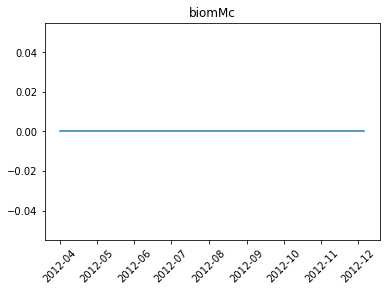

LitTige


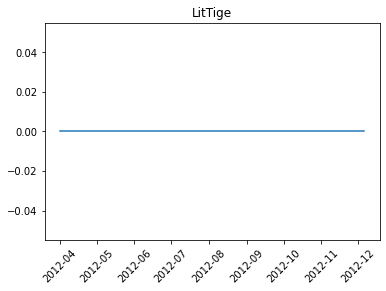

ltr


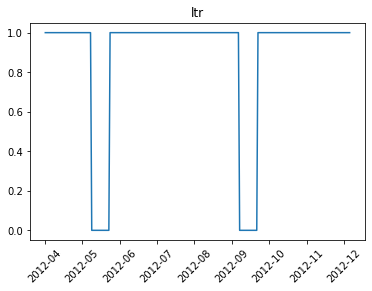

stRurMax


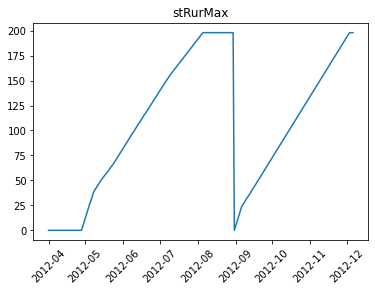

ruSurf


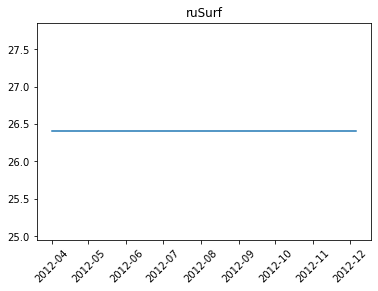

stTot


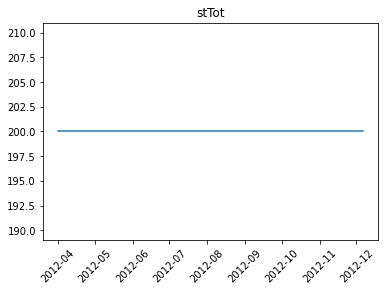

profRu


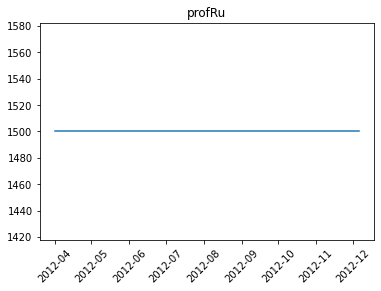

hum


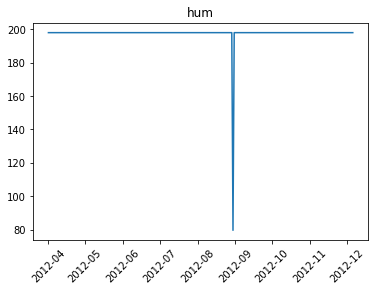

humPrec


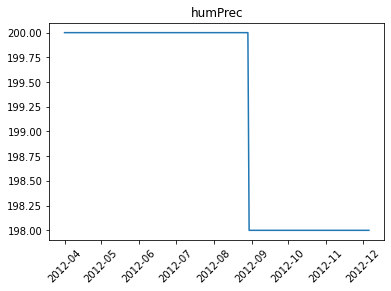

stRuPrec


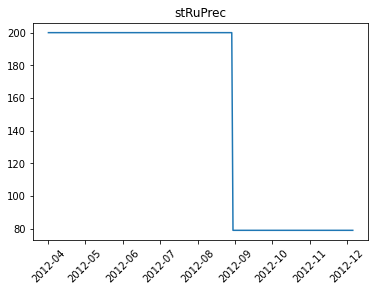

sommeDegresJourMaximale


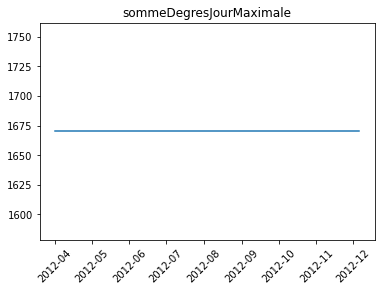

numPhase


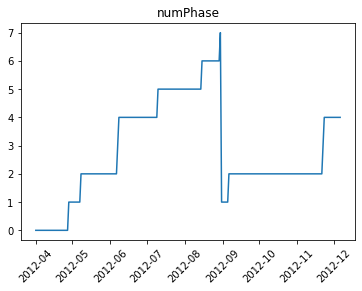

sdj


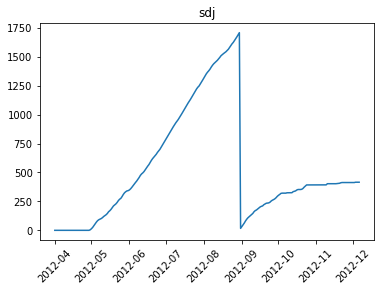

biomasseAerienne


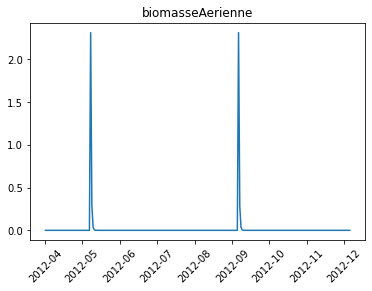

biomasseVegetative


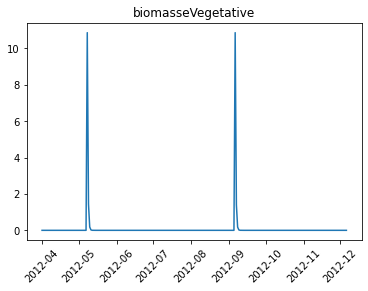

biomasseTotale


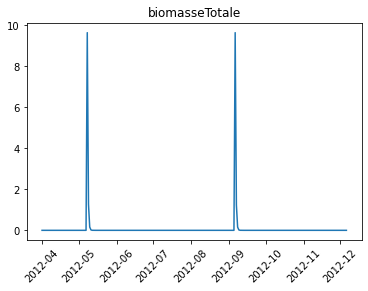

biomasseTiges


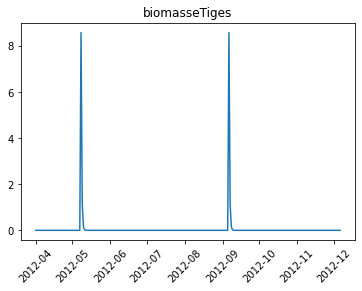

biomasseRacinaire


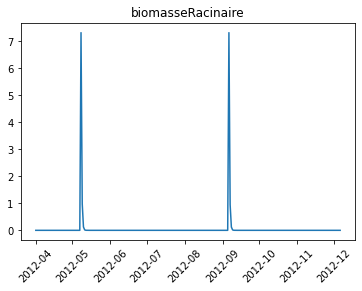

biomasseFeuille


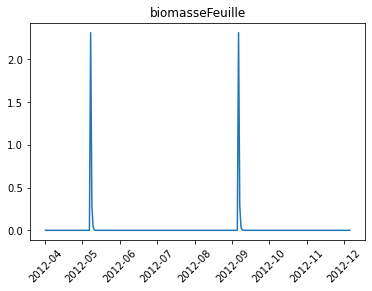

deltaBiomasseTotale


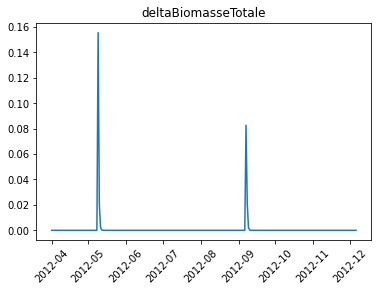

seuilTempPhaseSuivante


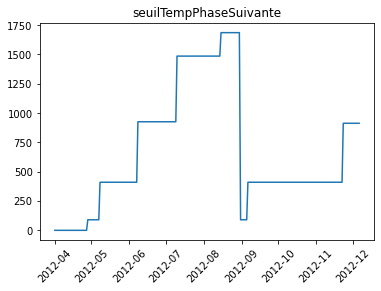

lai


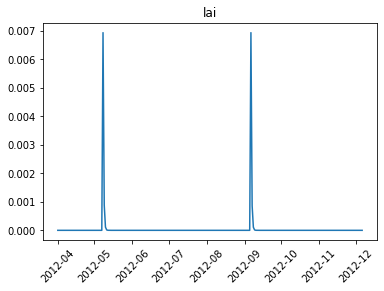

ddj


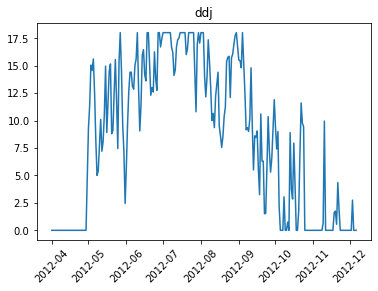

phasePhotoper


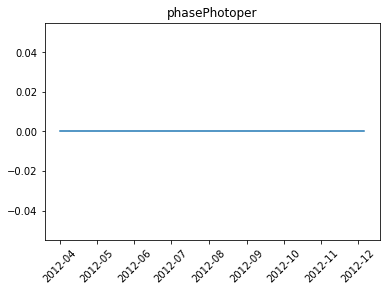

changePhase


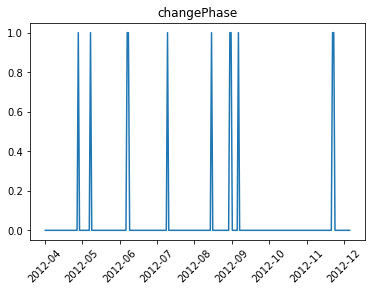

correctedIrrigation


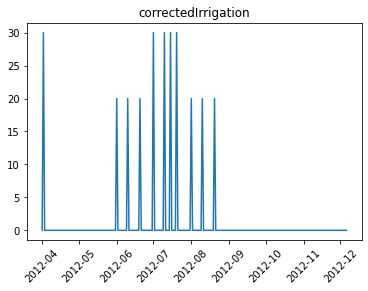

stockIrr


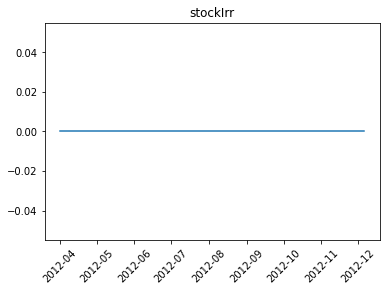

ruIrr


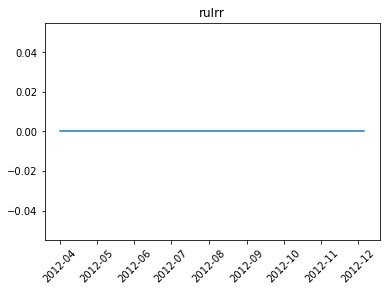

irrigTotDay


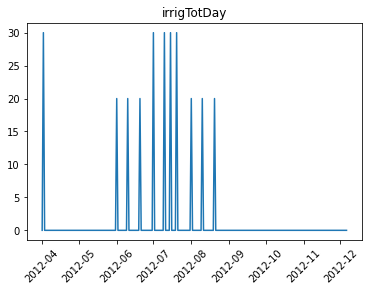

eauDispo


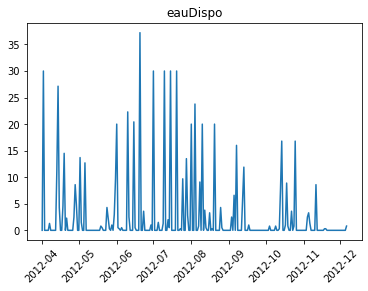

sommeIrrig


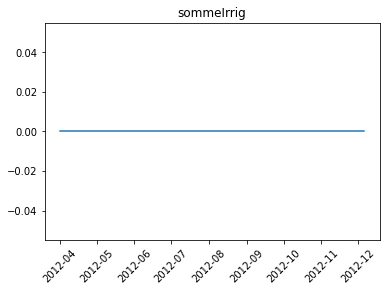

stockMc


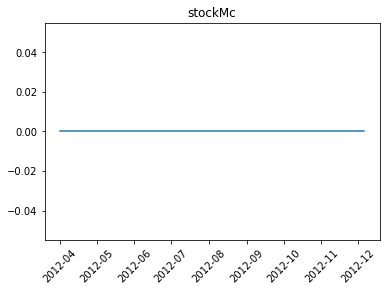

eauCaptee


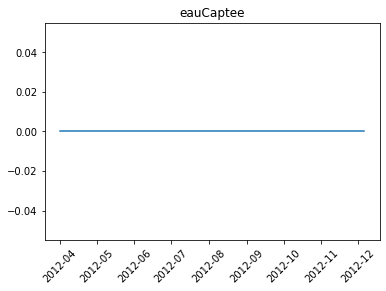

lr


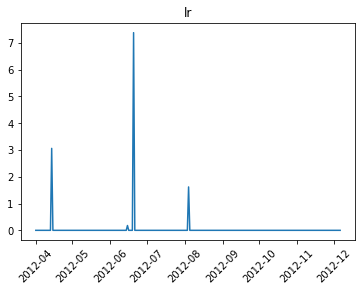

ruRac


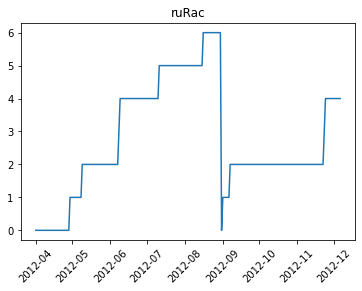

vRac


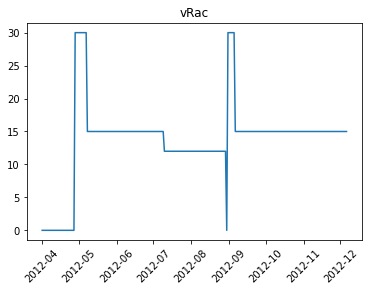

cstr


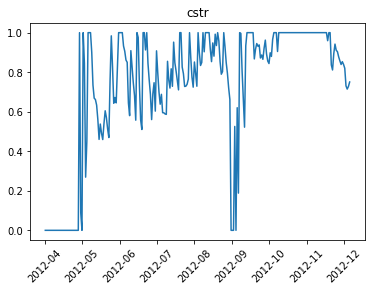

dayVrac


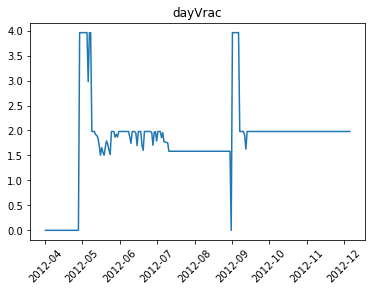

deltaRur


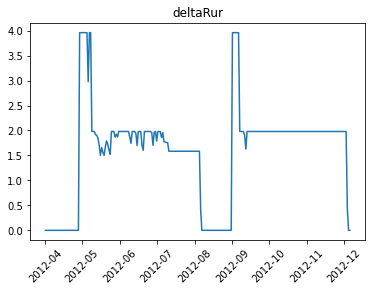

stockRac


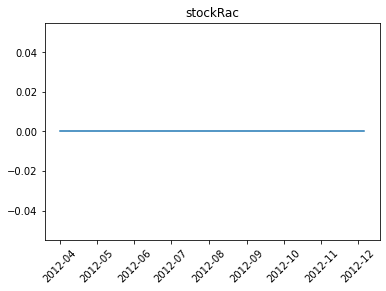

stRuMax


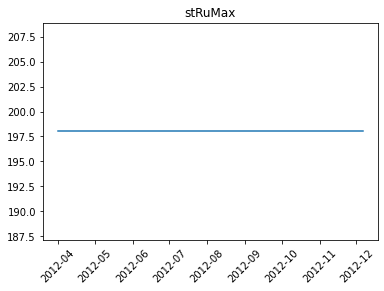

stRuSurfPrec


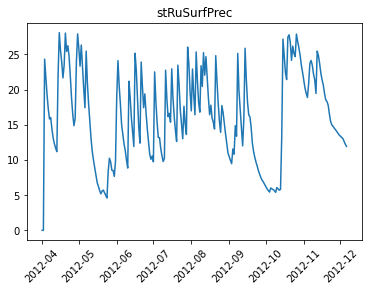

eauTranspi


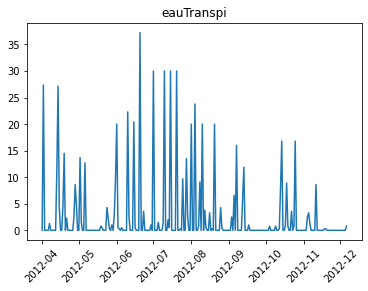

stockTotal


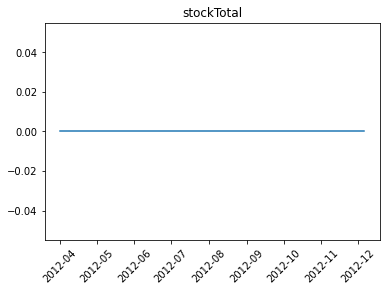

dr


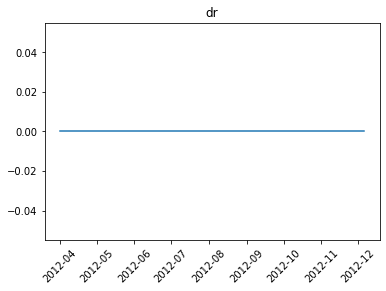

fesw


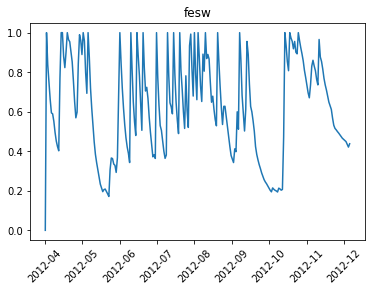

kce


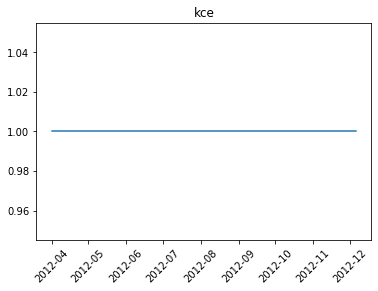

evapPot


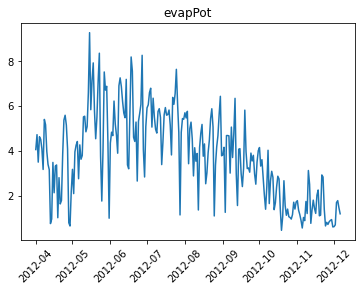

FEMcW


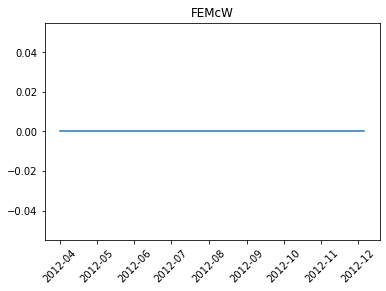

evap


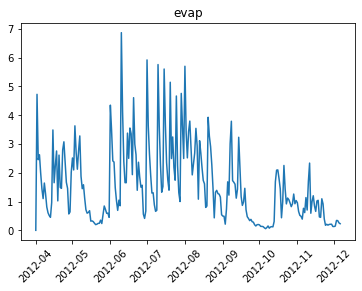

ftsw


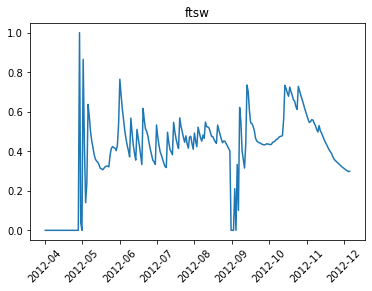

kcp


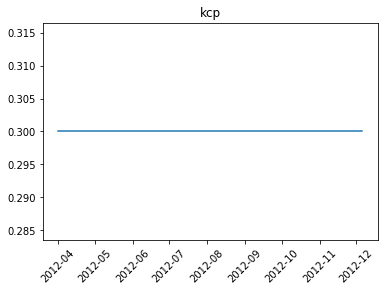

trPot


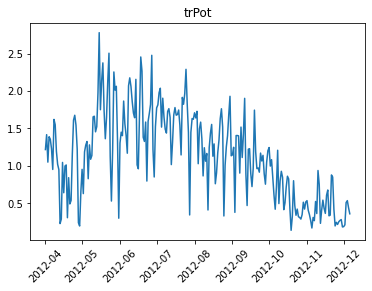

pFact


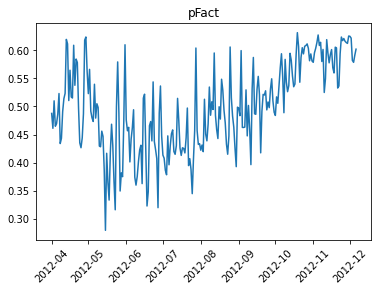

tr


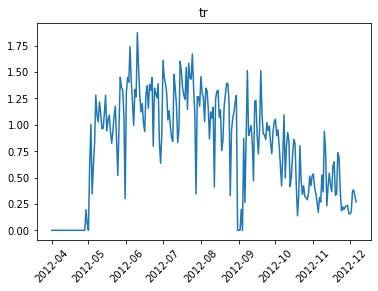

trSurf


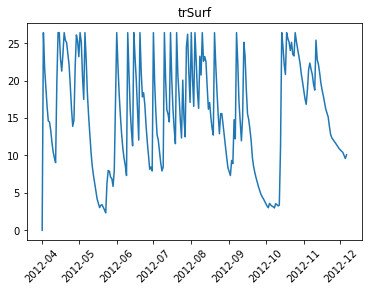

consoRur


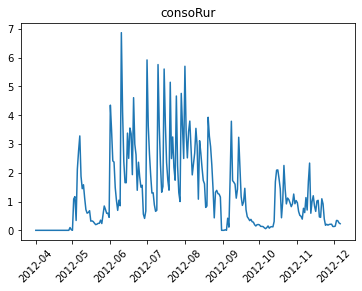

KAssim


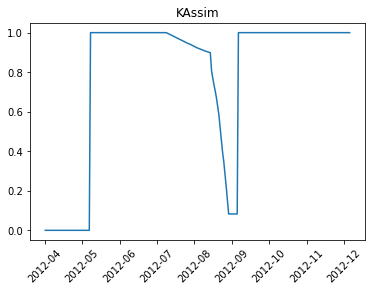

sommeDegresJourPhasePrec


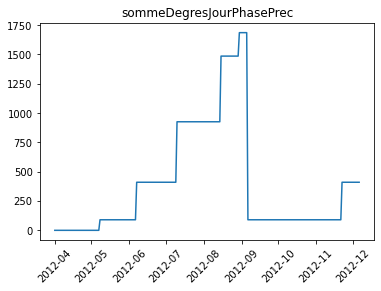

conv


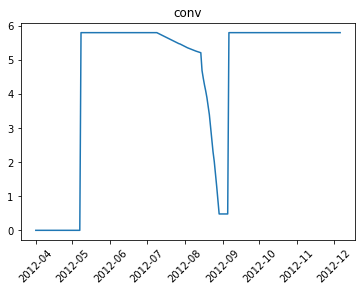

rdt


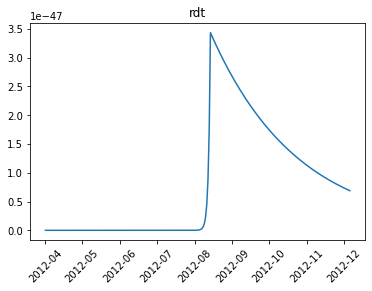

biomasseTige


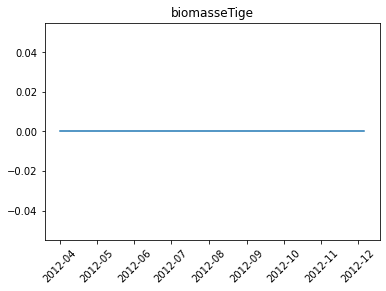

sla


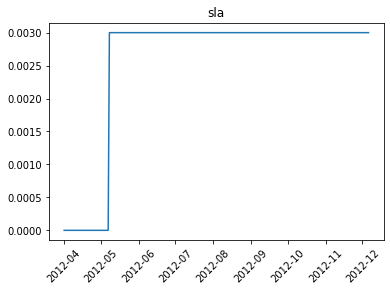

parIntercepte


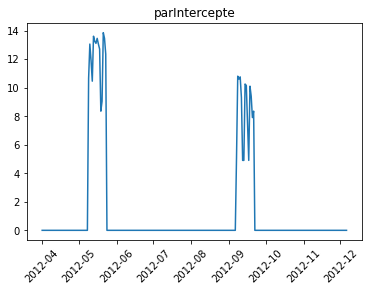

assimPot


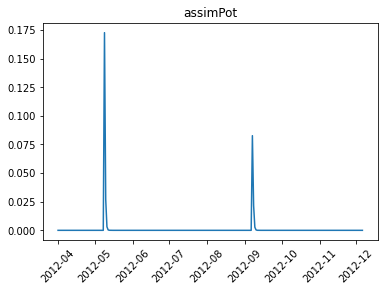

assim


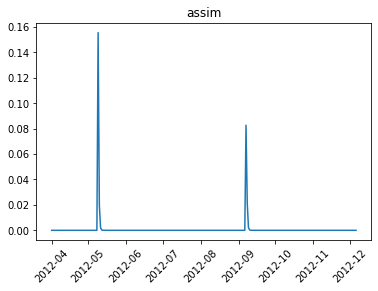

dRespMaint


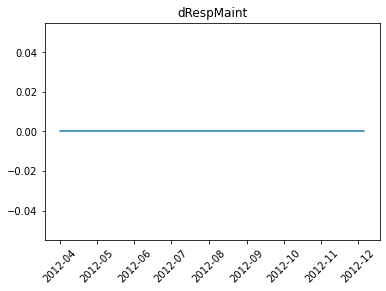

biomTotStadeIp


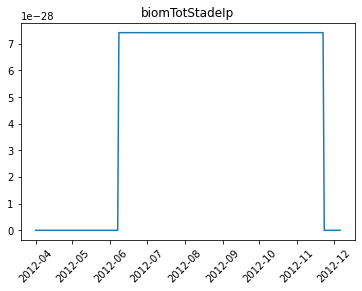

biomTotStadeFloraison


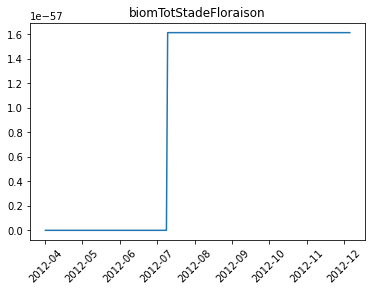

rdtPot


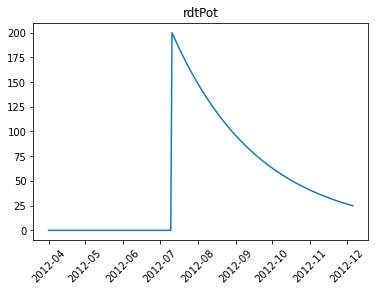

respMaint


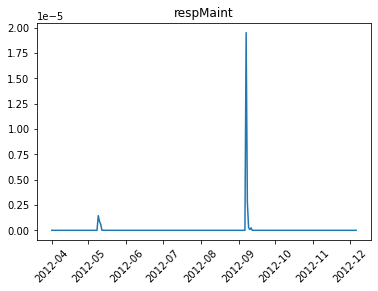

dRdtPot


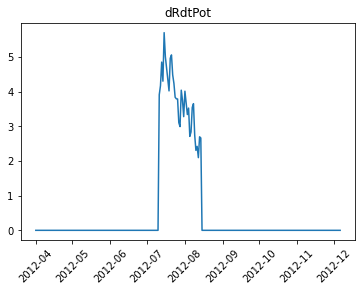

deltaBiomasseAerienne


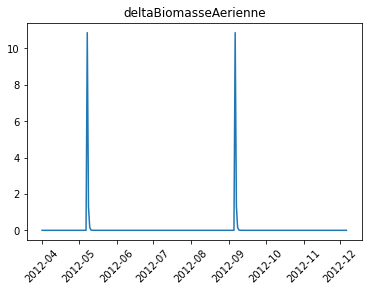

manqueAssim


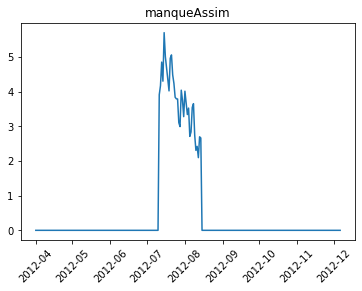

reallocation


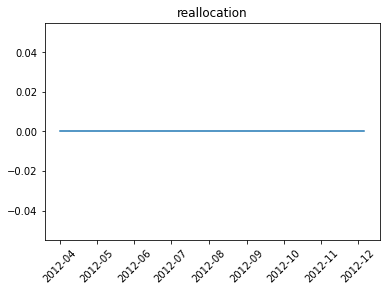

dayBiomLeaf


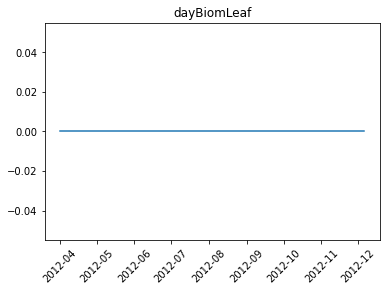

deltaBiomasseFeuilles


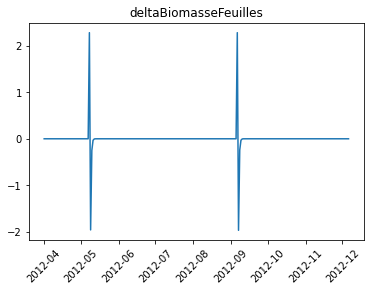

partFeuillesTiges


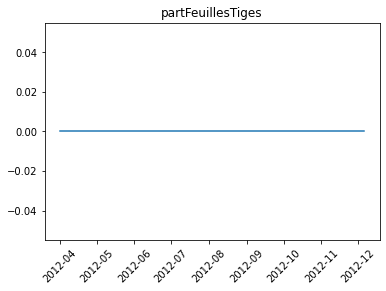

bM


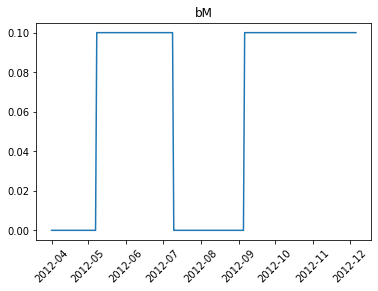

cM


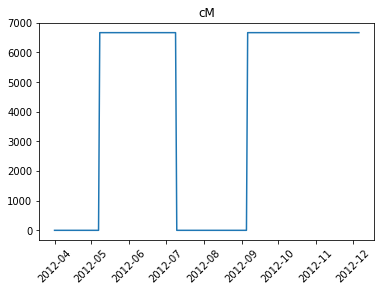

sumPP


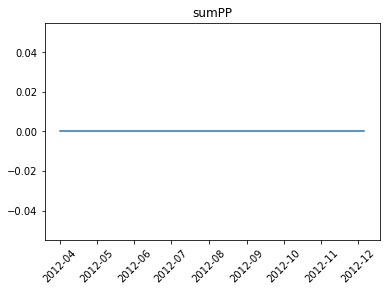

seuilTempPhasePrec


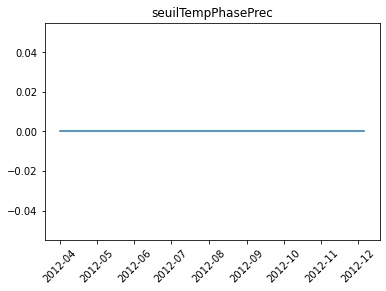

dureeDuJour


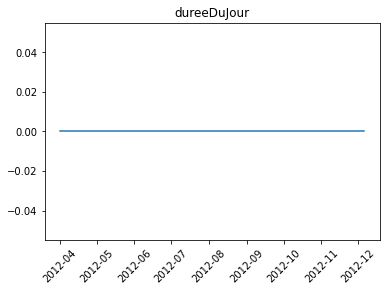

nbJourCompte


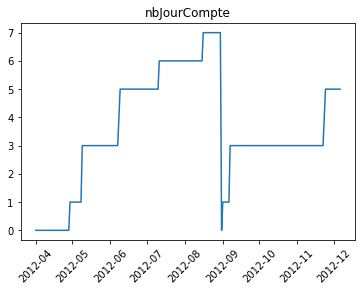

nbjStress


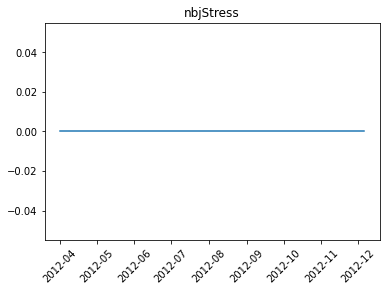

rapDensite
stRuSurf


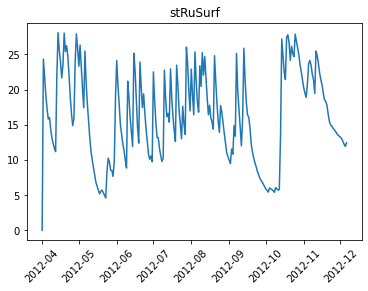

stRur


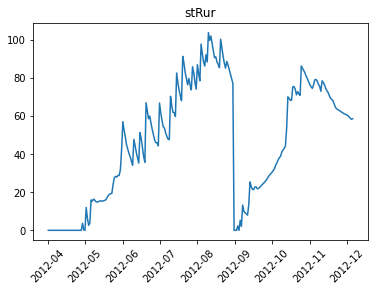

stRurMaxPrec


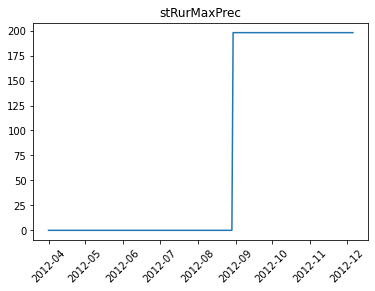

stRurPrec


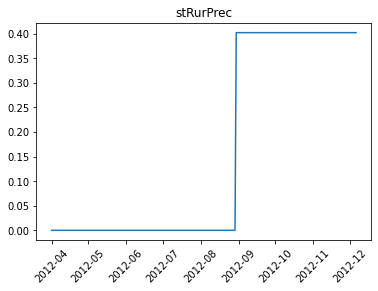

stRu


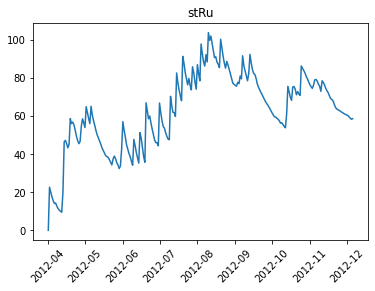

stRurSurf


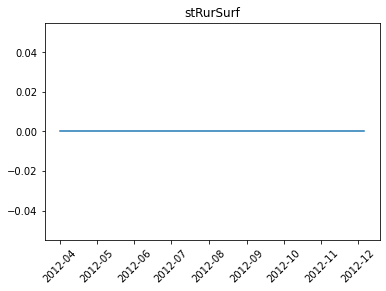

stRuVar


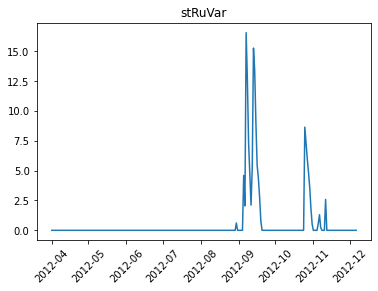

etp


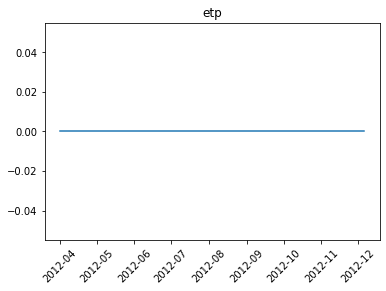

kcTot


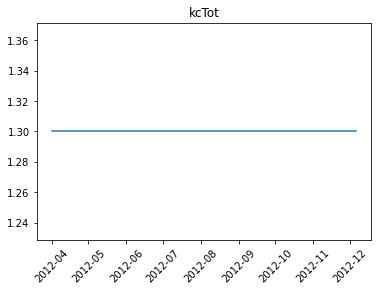

etr


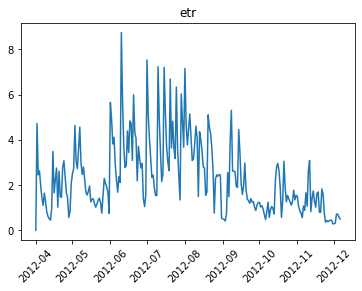

etm


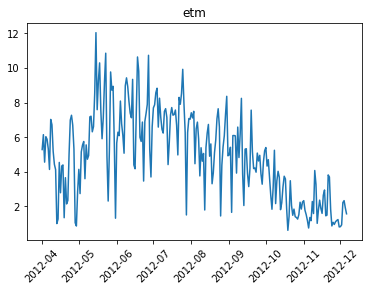

txConversion


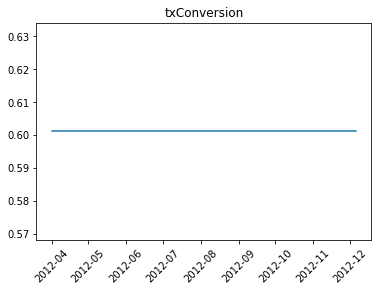

kRespMaint


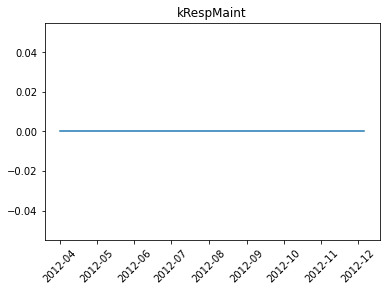

phaseDevVeg


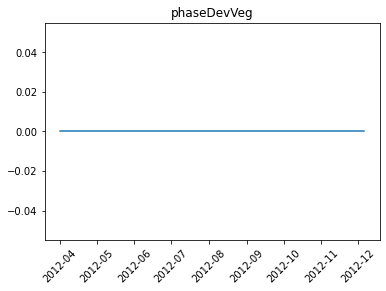

NbUBT


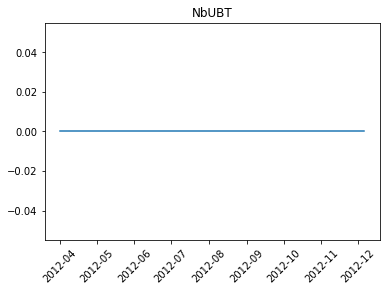

UBTCulture


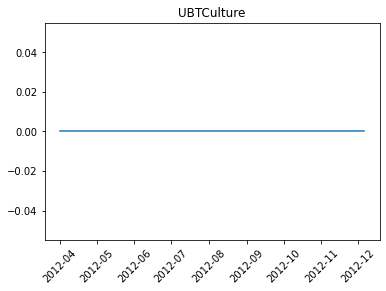

LitFeuille


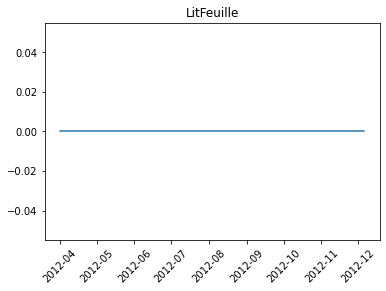

FeuilleUp


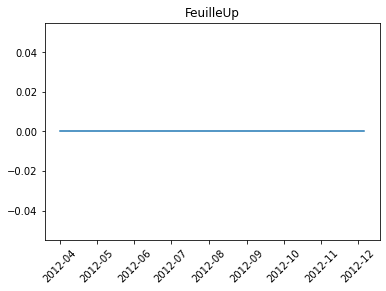

TigeUp


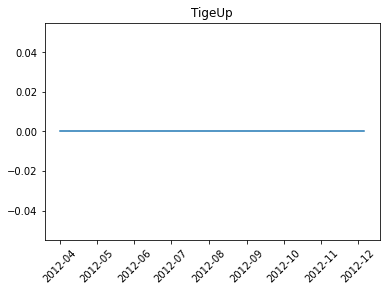

tpMoy


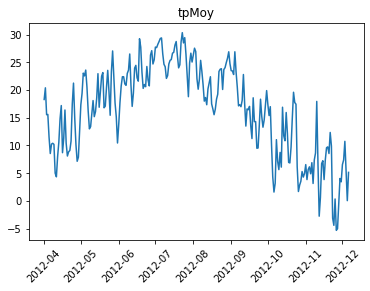

rain


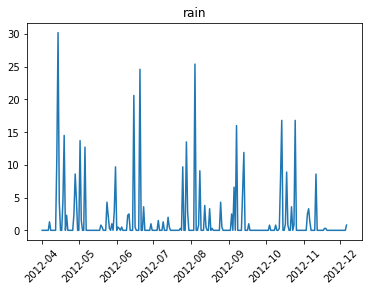

ET0


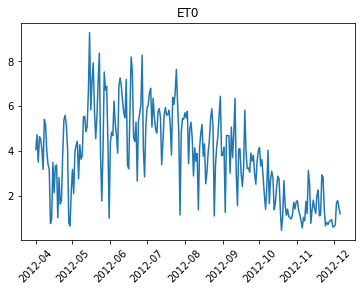

rg


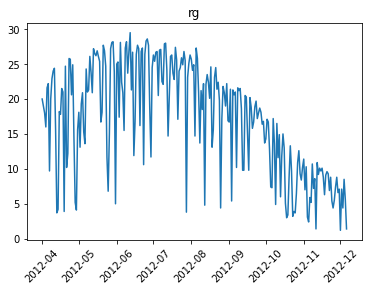

irrigation


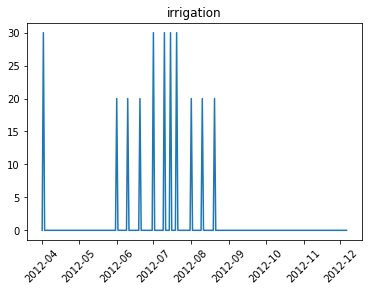

ru


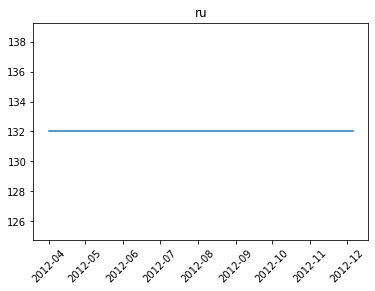

irrigAuto


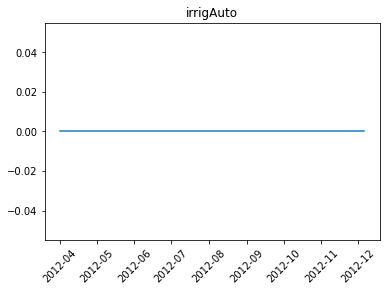

initPhase


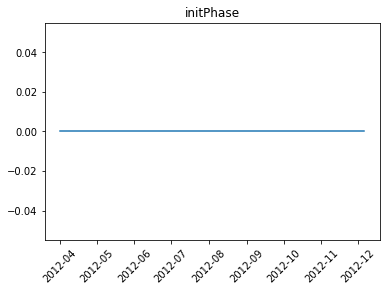

In [12]:
for variable in list(data) :
    print(variable)
    try:
        plt.plot(df_weather["Jour"], data[variable][0,0,:])
        plt.title(variable)
        plt.xticks(rotation=45)
        plt.show()
    except:
        pass

In [13]:
xxx

NameError: name 'xxx' is not defined

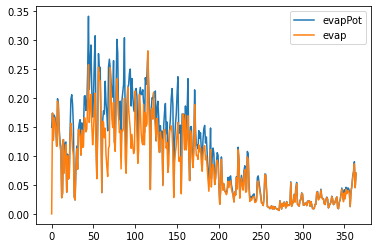

In [ ]:
# eau captée, eau dispo
plt.plot(data["evapPot"][0,0,:], label="evapPot")
plt.plot(data["evap"][0,0,:], label="evap")
plt.legend()
plt.title('')
plt.show()

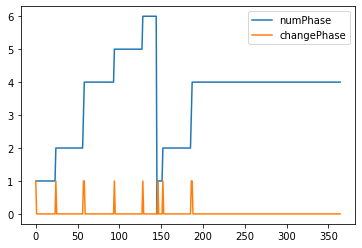

In [ ]:
# eau captée, eau dispo
plt.plot(data["numPhase"][0,0,:], label="numPhase")
plt.plot(data["changePhase"][0,0,:], label="changePhase")
plt.legend()
plt.title('')
plt.show()

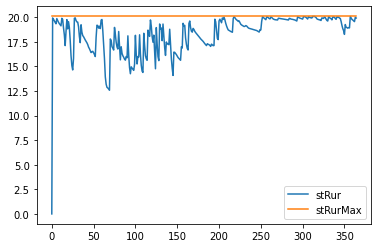

In [ ]:
# eau captée, eau dispo
plt.plot(data["stRu"][0,0,:], label="stRur")
plt.plot(data["stRuMax"][0,0,:], label="stRurMax")
plt.legend()
plt.title('')
plt.show()

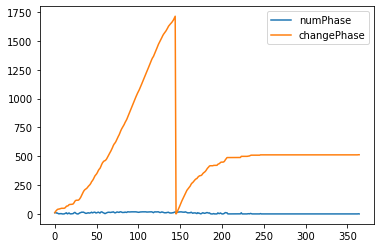

In [ ]:
# eau captée, eau dispo
plt.plot(data["ddj"][0,0,:], label="numPhase")
plt.plot(data["sdj"][0,0,:], label="changePhase")
plt.legend()
plt.title('')
plt.show()

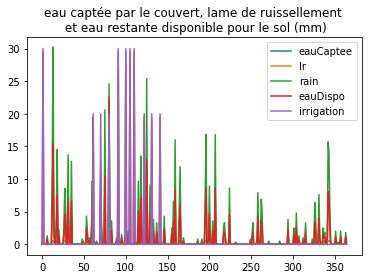

In [ ]:
# eau captée, eau dispo
plt.plot(data["eauCaptee"][0,0,:], label="eauCaptee")
plt.plot(data["lr"][0,0,:], label="lr")
plt.plot(data["rain"][0,0,:], label="rain")
plt.plot(data["eauDispo"][0,0,:], label="eauDispo")
plt.plot(data["irrigation"][0,0,:], label="irrigation")


plt.legend()
# plt.yscale("log")
plt.title('eau captée par le couvert, lame de ruissellement \n et eau restante disponible pour le sol (mm)')
plt.show()

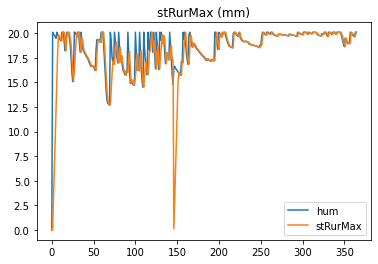

In [ ]:
# eau captée, eau dispo
plt.plot(data["hum"][0,0,:], label="hum")
plt.plot(data["stRurMax"][0,0,:], label="stRurMax")
plt.legend()
plt.title('stRurMax (mm)')
plt.show()

debugging

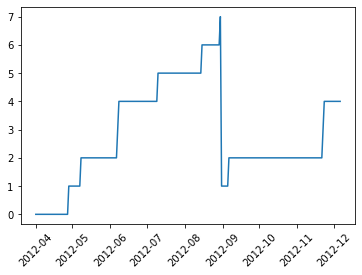

In [ ]:
        plt.plot(df_weather["Jour"], data["numPhase"][0,0,:])
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
paramITK["seuilEauSemis"]

0

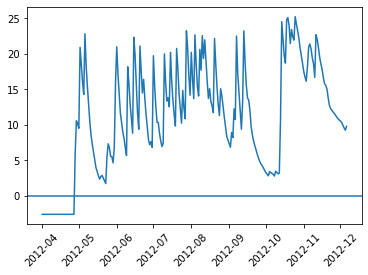

In [ ]:
        plt.plot(df_weather["Jour"], data["stRuSurf"][0,0,:]-data["ruSurf"][0,0,:]/10 )
        plt.axhline(y= paramITK["seuilEauSemis"] )
        plt.xticks(rotation=45)
        plt.show() 

In [ ]:
(data["stRuSurf"] - data["ruSurf"] / 10 >= paramITK["seuilEauSemis"])

array([[[False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,